In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import random
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

In [2]:
import scipy.io as sio
import scipy.misc as scimisc
safe_list = [0,2,5,6,8,12,13,14,15,16,17,18,19,21,26]  # other alphabets have characters which look like digits
m = sio.loadmat("./data/data_background.mat")

squished_set = []
for safe_number in safe_list:
    for alphabet in m['images'][safe_number]:
        for letters in alphabet:
            for letter in letters:
                for example in letter:
                    squished_set.append(scimisc.imresize(1 - example[0], (28,28)).reshape(1, 28*28))

safe_images = np.concatenate(squished_set, axis=0)

/Users/senqicao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/mnist', validation_size=0, one_hot=True)
test_len = mnist.test.images.shape[0]
validation_len = int(test_len * 0.1)
num_label=10
train_x = mnist.train.images
test_x = mnist.test.images[validation_len : test_len, :]
validation_x = mnist.test.images[ : validation_len, :]

train_y = mnist.train.labels
test_y = mnist.test.labels[validation_len : test_len]
validation_y = mnist.test.labels[ : validation_len]

print("\nTraining X shape: " + str(train_x.shape))
print("Testing X shape: " + str(test_x.shape))
print("Validation X shape: " + str(validation_x.shape))

print("\nTraining Y shape: " + str(train_y.shape))
print("Testing Y shape: " + str(test_y.shape))
print("Validation Y shape: " + str(validation_y.shape))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.

Training X shape: (60000, 784)
Testing X shape: (9000, 784)
Validation X shape: (1000, 784)

Training Y shape: (60000, 10)
Testing Y shape: (9000, 10)
Validation Y shape: (1000, 10)


In [4]:
tf.reset_default_graph()
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
h1=512
num_iter = 5000
batch_size = 100
networks = ['network1', 'network2', 'network3', 'network4', 'network5']
#networks = ['network1', 'network2']

def get_network(network_name):
    
    
    with tf.variable_scope(network_name):
        x_image = tf.placeholder(tf.float32, shape = [None, 28, 28, 1],name = network_name + 'x' )
        learning_rate = tf.placeholder(tf.float32,shape=(),name=network_name +'learning_rate')
        b = tf.placeholder(tf.bool,shape=(),name=network_name +'b')
        w_conv1 = tf.get_variable(network_name + 'w_conv1', [5,5, 1,32], initializer = tf.contrib.layers.xavier_initializer())
        w_conv2 = tf.get_variable(network_name + 'w_conv2', [5,5,32,64], initializer = tf.contrib.layers.xavier_initializer())
        w0 = tf.get_variable(network_name + 'w_fc1', [7*7*64, h1], initializer = tf.contrib.layers.xavier_initializer())
        b0 = tf.get_variable(network_name + 'b_fc1', [1,h1], initializer = tf.contrib.layers.xavier_initializer())
        w1 = tf.get_variable(network_name + 'w_fc2', [h1, 10], initializer = tf.contrib.layers.xavier_initializer())
        b1 = tf.get_variable(network_name + 'b_fc2', [1,10], initializer = tf.contrib.layers.xavier_initializer())
        # network
        con1 = tf.nn.conv2d(x_image, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
        h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
        #h_conv1 = tf.nn.relu(con1)
        h_pool1 = max_pool_2x2(h_conv1)

        con2 = tf.nn.conv2d(h_pool1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
        h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
        #h_conv2 = tf.nn.relu(con2)
        h_pool2 = max_pool_2x2(h_conv2)

        h_pool2_flat = tf.layers.flatten(h_pool2)

        h = tf.nn.relu(tf.matmul(h_pool2_flat, w0) + b0)
        logits = tf.matmul(h, w1) + b1
        output = tf.nn.softmax(logits)

        y_label = tf.placeholder(tf.float32, shape = [None, 10],name = network_name + 'y' )

        loss = tf.reduce_mean(tf.div(tf.reduce_sum(tf.square(tf.subtract(output, y_label)), axis = 1), num_label), axis = 0) 
        cross_ent = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=y_label)


    # Get trainable variables
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, network_name)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, network_name)
    #update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        #train_opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list = train_vars)
        train_opt = tf.train.AdamOptimizer(learning_rate).minimize(cross_ent, var_list = train_vars)
        #train_opt = tf.train.AdamOptimizer(learning_rate).minimize(cross_ent)
    return x_image, y_label, output, cross_ent, train_opt, train_vars, b, learning_rate

In [5]:
x_list = []
y_list = []
output_list = []
loss_list = []
train_list = []
train_var_list = []
b_list=[]
learning_rate_list = []

# Train each ensemble network
for i in range(len(networks)):
    x_image, y_label, output, loss, train_opt, train_vars, b, learning_rate = get_network(networks[i])

    x_list.append(x_image)
    y_list.append(y_label)
    output_list.append(output)
    loss_list.append(loss)
    train_list.append(train_opt)
    train_var_list.append(train_vars)
    b_list.append(b)
    learning_rate_list.append(learning_rate)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
# Create Session
saver = tf.train.Saver(max_to_keep = 200)
config = tf.ConfigProto()
#sess = tf.InteractiveSession(config=config)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
model_id=0
#save_path = saver.restore(sess, "./ensemble/classification_mnist33/model.ckpt")

In [7]:
def making_batch(data_size, sample_size, data_x, data_y):
    # Making batches(testing)
    batch_idx = np.random.choice(data_size, sample_size)
    
    batch_x = np.zeros([sample_size, img_size, img_size, 1])
    batch_y = np.zeros([sample_size, num_label])
        
    for i in range(batch_idx.shape[0]):
        batch_x[i,:,:,:] = np.reshape(data_x[batch_idx[i], :], (img_size, img_size, 1))
        batch_y[i,:]     = data_y[batch_idx[i], :] 
        
    return batch_x, batch_y

In [23]:
test_size = 10000

num_iter = 60000
batch_size = 100

train_data_num = train_x.shape[0]
test_data_num  = test_x.shape[0]
img_size=28
safe_images = np.reshape(safe_images,[9200,28,28,1])

for iter in range(num_iter):
    if iter < 1000:
        a = 0.0005
    elif iter < 5000:
        a = 0.0001
    elif iter < 20000:
        a = 0.00005
    elif iter < 30000:
        a = 0.00002
    elif iter < 40000:
        a = 0.000007
    else:
        a = 0.000002
    #test
    if iter % 100 == 0:
        
        x_batch_test = np.reshape(mnist.test.images,[10000, 28, 28, 1])
        y_batch_test = mnist.test.labels
        
        '''
        outputs=[]
        for i in range(len(networks)):
            prob = []
            for ii in range(0,100):
                igms_in = x_batch_test[ii*100:(ii+1)*100]
                labels_in = y_batch_test[ii*100:(ii+1)*100]
                prob_batch = sess.run(output_list[i], {x_list[i]:igms_in, y_list[i]:labels_in, b_list[i]:False})
                prob.extend(prob_batch)
            outputs.append(prob)
        '''
        outputs=[]
        for i in range(len(networks)):
            prob= sess.run(output_list[i], {x_list[i]:x_batch_test, y_list[i]:y_batch_test, b_list[i]:False})
            outputs.append(prob)
        outputs=np.array(outputs) 

        accs = np.mean(np.argmax(outputs,2)==np.argmax(y_batch_test,1),1)
        print("accs: ",accs)
        
        softmax = np.mean(outputs,0)
        maxp_in = np.max(softmax,1)
        acc = np.mean(np.argmax(softmax,1) ==  np.argmax(y_batch_test,1))
        print( iter, 'Final Testing Accuracy: ', acc)

        ent_in = np.sum(-np.log(softmax+1e-11)*softmax,1)
        Eent_in = np.mean(np.sum(-np.log(outputs+1e-11)*outputs,2),0)
        MI_in = ent_in - Eent_in
        '''
        outputs_OOD=[]
        for j in range(len(networks)):
            prob_OOD=[]
            for jj in range(0,92):
                igms_in_OOD = safe_images[jj*100:(jj+1)*100]
                labels_in_OOD = safe_images[jj*100:(jj+1)*100]
                prob_batch_OOD = sess.run(output_list[j], {x_list[j]:igms_in_OOD, b_list[j]:False})
                prob_OOD.extend(prob_batch_OOD)
            outputs_OOD.append(prob_OOD)
        '''   
        outputs_OOD=[]
        for j in range(len(networks)):
            prob_OOD = sess.run(output_list[j], {x_list[j]:safe_images1, b_list[j]:False})
            outputs_OOD.append(prob_OOD)
        outputs_OOD = np.array(outputs_OOD) 

        softmax_OOD = np.mean(outputs_OOD,0)
        maxp_OOD = np.max(softmax_OOD,1)
        ent_OOD = np.sum(-np.log(softmax_OOD+1e-11)*softmax_OOD,1)
        Eent_OOD = np.mean(np.sum(-np.log(outputs_OOD+1e-11)*outputs_OOD,2),0)
        MI_OOD = ent_OOD - Eent_OOD
        
        print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
        print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
        print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
        print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "ent_in:", np.mean(MI_in),np.std(MI_in))

        safe, risky  = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[9200,1])
        labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
        labels[safe.shape[0]:] += 1
        examples = np.squeeze(np.vstack((safe, risky)))
        print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
        print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

        safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[9200,1])
        labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
        labels[safe.shape[0]:] += 1
        examples = np.squeeze(np.vstack((safe, risky)))
        print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
        print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))
        
        safe, risky = np.reshape(MI_in,[10000,1]), np.reshape(MI_OOD,[9200,1])
        labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
        labels[safe.shape[0]:] += 1
        examples = np.squeeze(np.vstack((safe, risky)))
        print('AUPR_MI:', round(100*average_precision_score(labels, examples), 2))
        print('AUROC_MI:', round(100*roc_auc_score(labels, examples), 2))
        print("############################################")
 
    #train
    #batch = mnist.train.next_batch(batch_size)
    #x_batch = np.reshape(batch[0],[batch_size, 28, 28, 1])
    #y_batch = batch[1]
    for k in range(len(networks)):
        x_batch0, y_batch0 = making_batch(60000, batch_size, train_x, train_y)
        sess.run(train_list[k], {x_list[k]:x_batch0,y_list[k]: y_batch0, b_list[k]:True, learning_rate_list[k]:a})

    if iter%500==0:
        save_path = saver.save(sess, "./ensemble/classification_mnist%s/model.ckpt" % model_id)
        model_id+=1

KeyboardInterrupt: 

In [8]:
25000/500

50.0

## evaluations

In [9]:
sess = tf.Session()
model_id=0
save_path = saver.restore(sess, "./ensemble/classification_mnist50/model.ckpt")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./ensemble/classification_mnist50/model.ckpt


In [24]:
test_size = 10000

num_iter = 60000
batch_size = 100

train_data_num = train_x.shape[0]
test_data_num  = test_x.shape[0]
img_size=28
safe_images = np.reshape(safe_images,[9200,28,28,1])
safe_images1 = np.reshape(NotMNIST_x[:9200]/255 ,[9200,28,28,1])

for iter in range(num_iter):
    #test
    if iter % 100 == 0:
        
        x_batch_test = np.reshape(mnist.test.images,[10000, 28, 28, 1])
        y_batch_test = mnist.test.labels
        
        '''
        outputs=[]
        for i in range(len(networks)):
            prob = []
            for ii in range(0,100):
                igms_in = x_batch_test[ii*100:(ii+1)*100]
                labels_in = y_batch_test[ii*100:(ii+1)*100]
                prob_batch = sess.run(output_list[i], {x_list[i]:igms_in, y_list[i]:labels_in, b_list[i]:False})
                prob.extend(prob_batch)
            outputs.append(prob)
        '''
        outputs=[]
        for i in range(len(networks)):
            prob= sess.run(output_list[i], {x_list[i]:x_batch_test, y_list[i]:y_batch_test, b_list[i]:False})
            outputs.append(prob)
        outputs=np.array(outputs) 

        accs = np.mean(np.argmax(outputs,2)==np.argmax(y_batch_test,1),1)
        print("accs: ",accs)
        
        softmax = np.mean(outputs,0)
        maxp_in = np.max(softmax,1)
        acc = np.mean(np.argmax(softmax,1) ==  np.argmax(y_batch_test,1))
        print( iter, 'Final Testing Accuracy: ', acc)

        ent_in = np.sum(-np.log(softmax+1e-11)*softmax,1)
        Eent_in = np.mean(np.sum(-np.log(outputs+1e-11)*outputs,2),0)
        MI_in = ent_in - Eent_in
        '''
        outputs_OOD=[]
        for j in range(len(networks)):
            prob_OOD=[]
            for jj in range(0,92):
                igms_in_OOD = safe_images[jj*100:(jj+1)*100]
                labels_in_OOD = safe_images[jj*100:(jj+1)*100]
                prob_batch_OOD = sess.run(output_list[j], {x_list[j]:igms_in_OOD, b_list[j]:False})
                prob_OOD.extend(prob_batch_OOD)
            outputs_OOD.append(prob_OOD)
        '''   
        outputs_OOD=[]
        for j in range(len(networks)):
            prob_OOD = sess.run(output_list[j], {x_list[j]:safe_images1, b_list[j]:False})
            outputs_OOD.append(prob_OOD)
        outputs_OOD = np.array(outputs_OOD) 

        softmax_OOD = np.mean(outputs_OOD,0)
        maxp_OOD = np.max(softmax_OOD,1)
        ent_OOD = np.sum(-np.log(softmax_OOD+1e-11)*softmax_OOD,1)
        Eent_OOD = np.mean(np.sum(-np.log(outputs_OOD+1e-11)*outputs_OOD,2),0)
        MI_OOD = ent_OOD - Eent_OOD
        
        print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
        print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
        print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
        print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "ent_in:", np.mean(MI_in),np.std(MI_in))

        safe, risky  = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[9200,1])
        labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
        labels[safe.shape[0]:] += 1
        examples = np.squeeze(np.vstack((safe, risky)))
        print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
        print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

        safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[9200,1])
        labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
        labels[safe.shape[0]:] += 1
        examples = np.squeeze(np.vstack((safe, risky)))
        print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
        print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))
        
        safe, risky = np.reshape(MI_in,[10000,1]), np.reshape(MI_OOD,[9200,1])
        labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
        labels[safe.shape[0]:] += 1
        examples = np.squeeze(np.vstack((safe, risky)))
        print('AUPR_MI:', round(100*average_precision_score(labels, examples), 2))
        print('AUROC_MI:', round(100*roc_auc_score(labels, examples), 2))
        print("############################################")


accs:  [0.9928 0.9926 0.9925 0.9933 0.9932]
0 Final Testing Accuracy:  0.9941
maxp_OOD: 0.1608695652173913 0.71713835 0.20588084
maxp_inD: 0.976 0.99600136 0.034504868
ent_OOD: 0.66087085 0.42980337 ent_in: 0.0100405775 0.07455736
MI_OOD: 0.40128246 0.29531 ent_in: 0.0029300503 0.025471639
AUPR_p: 97.6
AUROC_p: 97.98
AUPR_entropy: 97.99
AUROC_entropy: 98.23
AUPR_MI: 98.43
AUROC_MI: 98.46
############################################


KeyboardInterrupt: 

In [16]:
img_size = 28
img_flat_size = img_size * img_size
folders_notMNIST = os.listdir('./data/notMNIST_small')

NotMNIST_x_list = []
NotMNIST_y_list = []

for idx, folder in enumerate(folders_notMNIST):
    files_notMNIST = os.listdir('./data/notMNIST_small/' + folder)
    
    for file in files_notMNIST:
        img_NotMNIST = cv2.imread('./data/notMNIST_small/' + folder + '/' + file, 0)
        NotMNIST_flat = np.reshape(img_NotMNIST, (img_flat_size))
        NotMNIST_x_list.append(NotMNIST_flat)
        
        label_temp = np.zeros([num_label])
        label_temp[idx] = 1
        
        NotMNIST_y_list.append(label_temp)
        
NotMNIST_x = np.stack(NotMNIST_x_list, axis = 0)
NotMNIST_y = np.stack(NotMNIST_y_list, axis = 0)

print("NotMNIST X shape: " + str(NotMNIST_x.shape))
print("NotMNIST Y shape: " + str(NotMNIST_y.shape))

NotMNIST X shape: (18724, 784)
NotMNIST Y shape: (18724, 10)


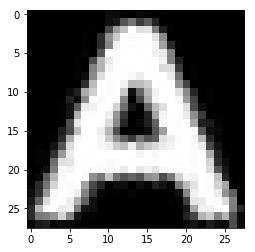

In [22]:
im = np.reshape(NotMNIST_x/255 ,[28,28])
plt.imshow(im,cmap='gray')
plt.show()

In [21]:
NotMNIST_x[0]/255

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04705882, 0.04313725, 0.00392157, 0.        , 0.03529412,
       0.01960784, 0.        , 0.00392157, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.05882353, 0.09019608,
       0.32156863, 0.45490196, 0.23921569, 0.34901961, 0.14117647,
       0.        , 0.00392157, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00784314,
       0.        , 0.2745098 , 0.61960784, 0.76862745, 1.        ,
       0.87058824, 0.88627451, 0.48627451, 0.12156863, 0.00784